# 🤪 変分オートエンコーダ - CelebA Faces

本ノートブックでは，CelebA Facesデータセットを用いて，独自の変分オートエンコーダーを訓練する．

注意：CPUでは途方もない時間がかかる．学習も行いたい場合はGPU環境で試してみてください．一応手元で学習したモデルもアップしてます．

In [4]:
!pip install japanize_matplotlib | tail -n 1
!pip install kagglehub | tail -n 1
!pip install torchinfo | tail -n 1

In [5]:
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import japanize_matplotlib
import torchvision
import torch
import torchinfo
import random
import pandas as pd
import kagglehub
from torch import nn
from torch.utils.data import DataLoader, Subset
import sys
print(sys.version)
print(torch.__version__)
print(torchvision.__version__)

3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
2.5.1+cu121
0.20.1+cu121


In [6]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.backends.mps.is_available():
        # MPSを使用する場合の設定
        torch.backends.mps.deterministic = True
    elif torch.cuda.is_available():
        # CUDAが利用可能な場合
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


# シード値を設定
set_seed(123)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(device)

cuda


## 0. パラメータ

In [3]:
IMAGE_SIZE = 32
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 128
Z_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 10
BETA = 2000

## 1. Prepare the data

In [7]:
# kakgglehubを使ってダウンロード -> pathに保存
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.33G/1.33G [01:08<00:00, 20.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2


In [8]:
# データ変換の定義
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    torchvision.transforms.ToTensor(),
])

# 分割情報(訓練データとテストデータを識別する情報）を読み込む
partition_df = pd.read_csv(os.path.join(path, "list_eval_partition.csv"), header=0)
file_to_partition = dict(zip(partition_df['image_id'], partition_df['partition'])) # partition: 0=train, 1=val, 2=test

# 属性情報を読み込み
attr_df = pd.read_csv(os.path.join(path, "list_attr_celeba.csv"), header=0, index_col=0)
attr_df = (attr_df + 1) // 2  # 属性を0/1に変換（-1を0、1を1に）
MULTI_CLASSES = np.array([
    "髭の剃り残し", "アーチ型の眉毛", "魅力的", "目の下のクマ",
    "禿げている", "前髪", "大きな唇", "大きな鼻", "黒髪", "金髪",
    "ぼやけた", "茶髪", "太い眉毛", "ふっくらしている", "二重あご",
    "眼鏡", "あごひげ", "白髪", "濃い化粧", "高い頬骨",
    "男性", "口が少し開いている", "口ひげ", "細い目", "ひげなし",
    "卵型の顔", "色白の肌", "先のとがった鼻", "後退する生え際",
    "バラ色の頬", "もみあげ", "笑っている", "直毛", "ウェーブのかかった髪",
    "イヤリングをしている", "帽子をかぶっている", "口紅をしている",
    "ネックレスをしている", "ネクタイをしている", "若い"
])
attr_df.columns = MULTI_CLASSES

# カスタムImageFolderを定義 (属性を返すように)
class CustomImageFolder(torchvision.datasets.ImageFolder):
    def __init__(self, root, transform=None, target_transform=None, attributes=None):
        super(CustomImageFolder, self).__init__(root, transform=transform, target_transform=target_transform)
        self.attributes = attributes

    def __getitem__(self, index):
        # 画像とラベルを取得
        path, _ = self.samples[index]
        image = self.loader(path)
        if self.transform is not None:
            image = self.transform(image)

        # 属性を取得
        filename = os.path.basename(path)
        attr = self.attributes.loc[filename].values.astype(float)

        return image, attr

# カスタムデータセットを作成
full_dataset = CustomImageFolder(
    root=path,
    transform=transform,
    attributes=attr_df
)

# データセットのインデックスを分割
train_indices = [i for i, (path, _) in enumerate(full_dataset.samples) if file_to_partition[os.path.basename(path)] == 0]
test_indices = [i for i, (path, _) in enumerate(full_dataset.samples) if file_to_partition[os.path.basename(path)] == 2]

# サブセットを作成
trainset = Subset(full_dataset, train_indices)
testset = Subset(full_dataset, test_indices)

# データローダーの作成
trainloader = DataLoader(
    trainset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True
)

testloader = DataLoader(
    testset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True
)
# from attr_df.columns (list_attr_celeba.csv)
# MULTI_CLASSES = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
#  'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
#  'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
#  'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
#  'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
#  'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
#  'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
#  'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
#  'Wearing_Necklace', 'Wearing_Necktie', 'Young']

tensor([[[0.9922, 0.9922, 0.9922,  ..., 0.4941, 0.6784, 0.9608],
         [0.9922, 0.9922, 0.9922,  ..., 0.4902, 0.7765, 0.9765],
         [0.9961, 0.9961, 0.9961,  ..., 0.5255, 0.8627, 0.9804],
         ...,
         [0.7373, 0.6941, 0.4706,  ..., 0.5686, 0.7608, 0.7725],
         [0.7529, 0.5373, 0.3216,  ..., 0.4667, 0.5294, 0.5725],
         [0.6510, 0.4706, 0.3529,  ..., 0.4706, 0.4392, 0.4275]],

        [[0.9059, 0.9059, 0.9059,  ..., 0.3098, 0.5373, 0.8941],
         [0.9059, 0.9059, 0.9059,  ..., 0.3020, 0.6549, 0.9216],
         [0.9176, 0.9137, 0.9137,  ..., 0.3451, 0.7725, 0.9333],
         ...,
         [0.4706, 0.4588, 0.2627,  ..., 0.3412, 0.5529, 0.5725],
         [0.4863, 0.2902, 0.1137,  ..., 0.2235, 0.3137, 0.3569],
         [0.3843, 0.2118, 0.1333,  ..., 0.2000, 0.1804, 0.1765]],

        [[0.7608, 0.7608, 0.7647,  ..., 0.1843, 0.4000, 0.7961],
         [0.7608, 0.7608, 0.7647,  ..., 0.1882, 0.5137, 0.8471],
         [0.7725, 0.7686, 0.7686,  ..., 0.2157, 0.6431, 0.

(3, 32, 32)
特徴一覧：
 ['目の下のクマ' '大きな鼻' '茶髪' '高い頬骨' '口が少し開いている' 'ひげなし' '笑っている' '若い']


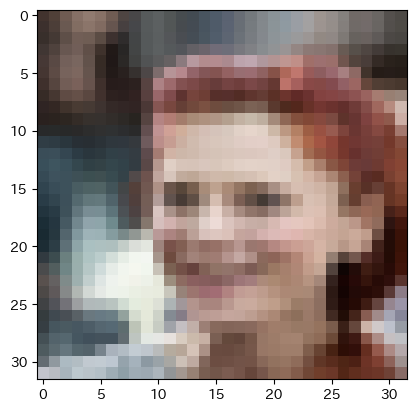

In [9]:
# データ確認
display(trainset[0][0])
# サイズ確認
print(np.array(trainset[0][0]).shape)
# データの可視化
print("特徴一覧：\n",MULTI_CLASSES[trainset[1][1] == 1])
plt.imshow(trainset[1][0].permute(1,2,0))
plt.show()

## 2. 変分オートエンコーダーの構築

In [10]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, kernel_size=(3, 3), out_channels=128, padding=1, stride=2) # 32 -> 16
        self.conv2 = nn.Conv2d(in_channels=128, kernel_size=(3, 3), out_channels=128, padding=1, stride=2) # 16 -> 8
        self.conv3 = nn.Conv2d(in_channels=128, kernel_size=(3, 3), out_channels=128, padding=1, stride=2) # 8 -> 4
        self.conv4 = nn.Conv2d(in_channels=128, kernel_size=(3, 3), out_channels=128, padding=1, stride=2) # 4 -> 2

        self.batchnorm1 = nn.BatchNorm2d(num_features=128)
        self.batchnorm2 = nn.BatchNorm2d(num_features=128)
        self.batchnorm3 = nn.BatchNorm2d(num_features=128)
        self.batchnorm4 = nn.BatchNorm2d(num_features=128)
        self.flatten = nn.Flatten()

        self.leaky_relu = nn.LeakyReLU()

        self.fc_mean = nn.Linear(in_features=2 * 2 * 128, out_features=Z_DIM)
        self.fc_log_var = nn.Linear(in_features=2 * 2 * 128, out_features=Z_DIM)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.leaky_relu(x)

        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.leaky_relu(x)

        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.leaky_relu(x)

        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = self.leaky_relu(x)

        x = self.flatten(x)

        z_means = self.fc_mean(x)
        z_log_vars = self.fc_log_var(x)
        z = self.sample_gaussian(z_means, z_log_vars)

        return z, z_means, z_log_vars

    def sample_gaussian(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(in_features=Z_DIM, out_features=2 * 2 * 128)
        self.deconv1 = nn.ConvTranspose2d(in_channels=128, kernel_size=(3, 3), out_channels=128, padding=1, output_padding=1, stride=2) # 2 -> 4
        self.deconv2 = nn.ConvTranspose2d(in_channels=128, kernel_size=(3, 3), out_channels=128, padding=1, output_padding=1, stride=2) # 4 -> 8
        self.deconv3 = nn.ConvTranspose2d(in_channels=128, kernel_size=(3, 3), out_channels=128, padding=1, output_padding=1, stride=2) # 8 -> 16
        self.deconv4 = nn.ConvTranspose2d(in_channels=128, kernel_size=(3, 3), out_channels=128, padding=1, output_padding=1, stride=2)  # 16 -> 32
        #self.conv1 = nn.Conv2d(in_channels=32, kernel_size=(3, 3), out_channels=3, padding=1, stride=1)
        self.deconv5 = nn.ConvTranspose2d(in_channels=128, kernel_size=(3, 3), out_channels=3, padding=1, output_padding=0, stride=1)  # 32 -> 32

        self.leaky_relu = nn.LeakyReLU()
        self.batchnorm1 = nn.BatchNorm1d(num_features=2 * 2 * 128)
        self.batchnorm2 = nn.BatchNorm2d(num_features=128)
        self.batchnorm3 = nn.BatchNorm2d(num_features=128)
        self.batchnorm4 = nn.BatchNorm2d(num_features=128)
        self.batchnorm5 = nn.BatchNorm2d(num_features=128)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc(x)
        x = self.batchnorm1(x)
        x = self.leaky_relu(x)
        x = x.view(-1, 128, 2, 2)
        x = self.deconv1(x)
        x = self.batchnorm2(x)
        x = self.leaky_relu(x)
        x = self.deconv2(x)
        x = self.batchnorm3(x)
        x = self.leaky_relu(x)
        x = self.deconv3(x)
        x = self.batchnorm4(x)
        x = self.leaky_relu(x)
        x = self.deconv4(x)
        x = self.batchnorm5(x)
        x = self.leaky_relu(x)
        x = self.deconv5(x) # x = self.conv1(x)
        x = self.sigmoid(x)
        return x


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z, z_means, z_log_vars = self.encoder(x)
        reconstructions = self.decoder(z)
        return reconstructions, z_means, z_log_vars

def loss_function(reconstructions, targets, z_means, z_log_vars, beta):
    # 再構成損失
    reconstruction_loss = nn.functional.binary_cross_entropy(input=reconstructions, target=targets, reduction='none')
    reconstruction_loss = reconstruction_loss.flatten(start_dim=1).mean(dim=1).mean()

    # KLダイバージェンス損失
    kl_divergence =  -0.5 * torch.sum((1 + z_log_vars - z_means.pow(2) - z_log_vars.exp()), axis=1).mean()

    return beta * reconstruction_loss + kl_divergence

In [11]:
vae = VAE()
encoder = vae.encoder
decoder = vae.decoder

In [12]:
# 全体の設計
torchinfo.summary(vae.eval(), input_size=(1, 3, 32, 32), verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [1, 3, 32, 32]            --
├─Encoder: 1-1                           [1, 200]                  --
│    └─Conv2d: 2-1                       [1, 128, 16, 16]          3,584
│    └─BatchNorm2d: 2-2                  [1, 128, 16, 16]          256
│    └─LeakyReLU: 2-3                    [1, 128, 16, 16]          --
│    └─Conv2d: 2-4                       [1, 128, 8, 8]            147,584
│    └─BatchNorm2d: 2-5                  [1, 128, 8, 8]            256
│    └─LeakyReLU: 2-6                    [1, 128, 8, 8]            --
│    └─Conv2d: 2-7                       [1, 128, 4, 4]            147,584
│    └─BatchNorm2d: 2-8                  [1, 128, 4, 4]            256
│    └─LeakyReLU: 2-9                    [1, 128, 4, 4]            --
│    └─Conv2d: 2-10                      [1, 128, 2, 2]            147,584
│    └─BatchNorm2d: 2-11                 [1, 128, 2, 2]         

In [13]:
opt = torch.optim.Adam(vae.parameters(), lr=LEARNING_RATE)
criterion = loss_function

In [14]:
vae = vae.to(device)
vae.train()
for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, _ = data
        inputs = inputs.to(device)
        opt.zero_grad()
        reconstructions, z_means, z_log_vars = vae(inputs)
        loss = criterion(reconstructions, inputs, z_means, z_log_vars, BETA)  # 元の入力と出力を比較してロスを計算
        loss.backward() # backpropagation
        opt.step() # モデルのパラメータ更新

        running_loss += loss.item() # 誤差の値を加算

    # epoch終了時点での誤算の平均値
    print(f'epoch {epoch + 1} loss: {running_loss / len(trainset):.4f}')

epoch 1 loss: 8.8647
epoch 2 loss: 8.5522
epoch 3 loss: 8.4993
epoch 4 loss: 8.4754
epoch 5 loss: 8.4639
epoch 6 loss: 8.4535
epoch 7 loss: 8.4464
epoch 8 loss: 8.4419
epoch 9 loss: 8.4373
epoch 10 loss: 8.4354


### 学習せずモデルロードする場合は以下

In [ ]:
import urllib.request

url = "https://raw.githubusercontent.com/sol-sun/Generative_Deep_Learning_2nd_Pytorch/blob//models/model.pth"
urllib.request.urlretrieve(url, "model.pth")

#def load_vae_model(model_class, path, device):
#    model = model_class()
#    model = model.to(device)
#    model.load_state_dict(torch.load(path, map_location=device)())
#    model.to(device)
#    print(f"Model loaded from {path}")
#    return model

## 読み込むファイルのパスを指定
#load_path = "./models/vae_faces_model.pth"

## モデルをデバイスに移動して読み込み
#vae = load_vae_model(VAE, load_path, device)

Model loaded from ./models/05_vae_faces_model.pth


In [16]:
# モデルを推論モードに切り替える
vae.eval()

# テストデータのサブセットを選択
#batches_to_predict = 1
dataloader = iter(trainloader)  # train_loaderはデータローダーとして事前に定義されていることを想定
example_images, _ = next(dataloader)  # バッチの画像を取得
example_images = example_images.to(device)

# PyTorchでの推論
with torch.no_grad():
    reconstructions, z_means, z_log_vars = vae(example_images)

元の画像


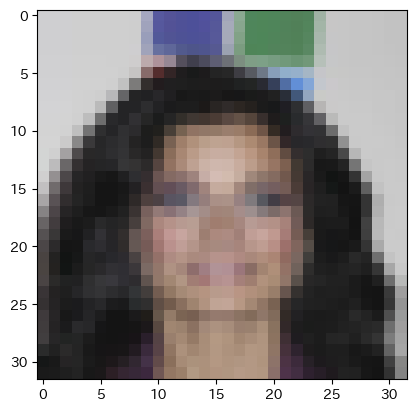

再構成画像


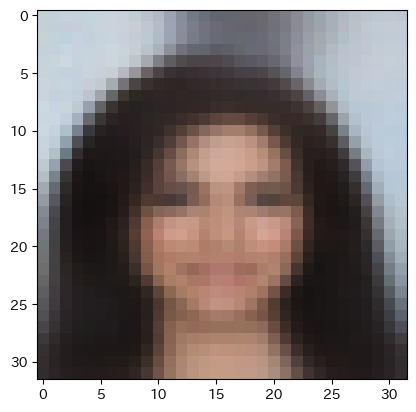

In [17]:
# PyTorchでの推論
with torch.no_grad():
    reconstructions, z_means, z_log_vars = vae(example_images)

# 結果を表示
print("元の画像")
i = 1
plt.imshow(example_images.cpu().detach().numpy()[i].transpose(1, 2, 0))
plt.show()
print("再構成画像")
plt.imshow(reconstructions.cpu().detach().numpy()[i].transpose(1, 2, 0))
plt.show()

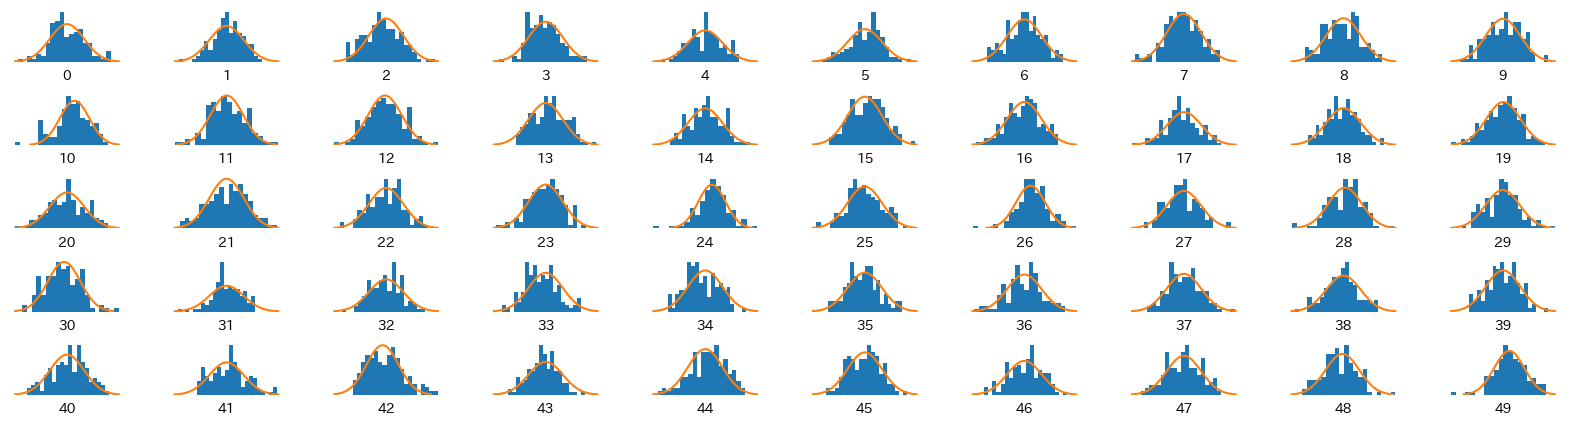

In [18]:
from scipy.stats import norm

# モデルを推論モードに切り替える
vae.eval()

# 入力データを指定されたデバイスに移動（例: "mps", "cuda", "cpu"）
example_images = example_images.to(device)

# エンコーダーからzを取得
with torch.no_grad():
    z, _, _ = vae.encoder(example_images)

# zをCPU上のNumPy配列に変換
z = z.cpu().numpy()

# x軸の範囲を設定
x = np.linspace(-3, 3, 100)

# グラフの設定
fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

# ヒストグラムを描画
for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(z[:, i], density=True, bins=20)
    ax.axis("off")
    ax.text(0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes)
    ax.plot(x, norm.pdf(x))

# グラフを表示
plt.show()

## 5. 新しい顔を生成する

In [23]:
# 潜在空間で標準正規分布からサンプリングする
grid_width, grid_height = (10, 3)
z_sample = torch.randn_like(torch.empty(grid_width * grid_height, Z_DIM))
z_sample = z_sample.to(device)

In [24]:
vae.eval()
# サンプルした点をデコードする
reconstructions = vae.decoder(z_sample)

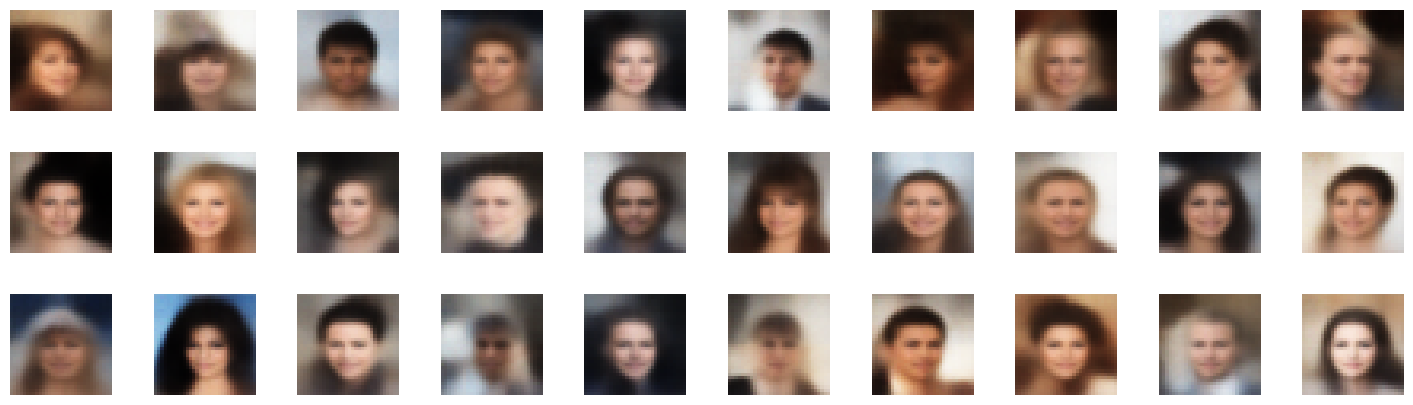

In [25]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :].detach().cpu().numpy().transpose(1, 2, 0))